# General

In [1]:
# Het importeren van de benodigde bilbiotheken
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import seaborn as sb
import scipy.stats

In [2]:
# Het inlezen van de bestanden
dfTelemetry = pd.read_csv('data/PdM_telemetry.csv')
dfErrors = pd.read_csv('data/PdM_errors.csv')
dfMaint = pd.read_csv('data/PdM_maint.csv')
dfFailures = pd.read_csv('data/PdM_failures.csv')
dfMachines = pd.read_csv('data/PdM_machines.csv')

In [3]:
# #Left join failures on maintenance to create df1
df1 = pd.merge(dfMaint, dfFailures, how='left', left_on=['datetime', 'machineID', 'comp'], right_on = ['datetime', 'machineID', 'failure'])
df1['failure'] = df1['failure'].fillna(0) #indicates maint was not a failure
df1.loc[((df1.failure == 'comp1') | (df1.failure == 'comp2') | (df1.failure == 'comp3') | (df1.failure == 'comp4')), 'failure'] = '1' #indicates maintenance was a failure
df1['failure'] = df1['failure'].astype(int)

#Clean error table to create df2, df2 = cleansed dfErrors tbl. 
df2 = dfErrors
df2['Error1'] = 0
df2['Error2'] = 0
df2['Error3'] = 0
df2['Error4'] = 0
df2['Error5'] = 0

df2.loc[(df2['errorID'] == 'error1'), 'Error1'] = 1
df2.loc[(df2['errorID'] == 'error2'), 'Error2'] = 1
df2.loc[(df2['errorID'] == 'error3'), 'Error3'] = 1
df2.loc[(df2['errorID'] == 'error4'), 'Error4'] = 1
df2.loc[(df2['errorID'] == 'error5'), 'Error5'] = 1

# # df2 = df2.groupby(['machineID', 'datetime']).sum() #Groups on all cols.
df2 = df2.groupby(['datetime', 'machineID'])[[f'Error{n}' for n in range (1,6)]].sum() #Groups errorID cols only

##Create df3 by joining dfTelemetry on df2
df3 = pd.merge(dfTelemetry, df2, how='left', left_on=['machineID', 'datetime'], right_on=['machineID', 'datetime'])

df3['Error1'] = df3['Error1'].fillna(0)
df3['Error2'] = df3['Error2'].fillna(0)
df3['Error3'] = df3['Error3'].fillna(0)
df3['Error4'] = df3['Error4'].fillna(0)
df3['Error5'] = df3['Error5'].fillna(0)

df3.Error1 = df3.Error1.astype(int)
df3.Error2 = df3.Error2.astype(int)
df3.Error3 = df3.Error3.astype(int)
df3.Error4 = df3.Error4.astype(int)
df3.Error5 = df3.Error5.astype(int)

## Create df4 by joining machines on df3
df4 = pd.merge(dfMachines, df3, how='right', left_on=['machineID'], right_on=['machineID'])

## Create df5 by joining df1 on df4
df5 = pd.merge(df1, df4, how='right', left_on=['machineID', 'datetime'], right_on=['machineID', 'datetime'])
df = df5

#Create dfSmall by inner joining df1 on df4
dfSmall = pd.merge(df1, df4)

# Linear regression of age and failures w/ pearson R line

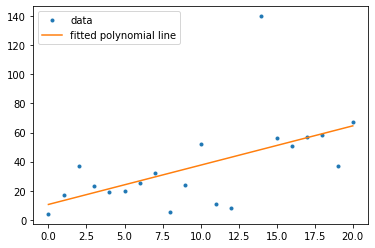

(0.5510960447796684, 0.01178620488671587)
SpearmanrResult(correlation=0.6619030178505663, pvalue=0.0014779478570042441)
KendalltauResult(correlation=0.48021275336982183, pvalue=0.0031369924990810386)


In [4]:
failureGroupAgedf = df['failure'].groupby(df['age']).sum().reset_index()
x = failureGroupAgedf['age']
y = failureGroupAgedf['failure']

# #polynomial
a, b = polyfit(x, y, 1)

_ = plt.plot(x, y, '.', label='data')
_ = plt.plot(x, a + b * x, '-', label='fitted polynomial line')
_ = plt.legend()
plt.show()

# #Linear
# m, b = np.linalg.lstsq(failureGroupAgedf, y)[0]

# _ = plt.plot(x,y, 'o', label='original data', markersize = 10)
# _ = plt.plot(x, m*x + b, 'r', label='fitted line')
# _ = plt.legend()
# plt.show()

print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x, y))
print(scipy.stats.kendalltau(x, y))

# print(failureGroupAgedf)

# plt.figure(figsize=[15,8])
# sb.heatmap(failureGroupAgedf.corr(),annot=True)

# Histogram with classification of voltage

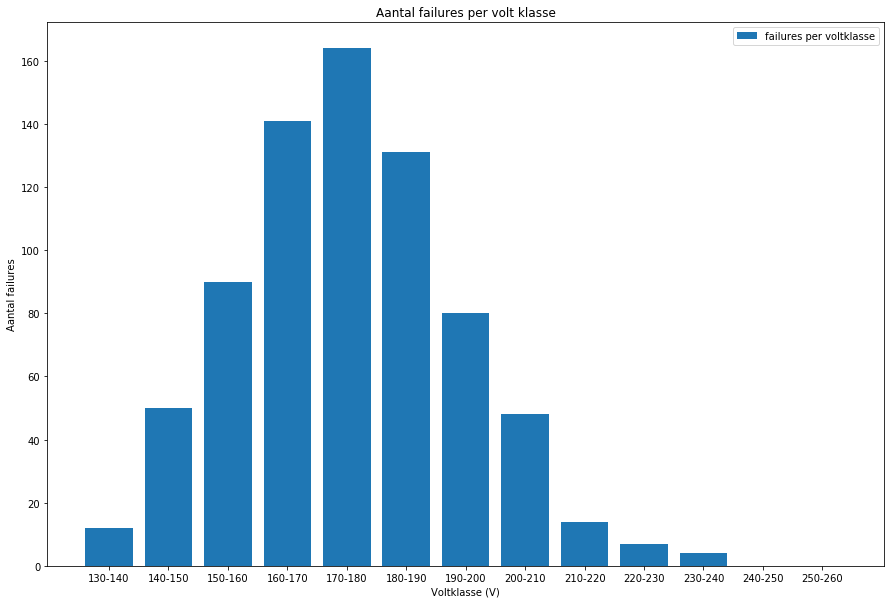

In [10]:
# volt min = 138.432075
# volt max = 255.124717
# bins: 130,140,150,160,170,180,190,200,210,220,230,240,250,260

toCut = dfSmall.volt
labelsUsed = [
        '130-140',
        '140-150',
        '150-160',
        '160-170',
        '170-180',
        '180-190',
        '190-200',
        '200-210',
        '210-220',
        '220-230',
        '230-240',
        '240-250',
        '250-260'
        ]

voltcat = pd.cut(toCut,bins=[130,140,150,160,170,180,190,200,210,220,230,240,250,260],
    labels=labelsUsed)
# dfSmall.insert(7,'voltage_class',voltcat) #Inserts the records into the new columns, but when executed again another code should be used(?)

## Building the graphic

# validation code to check the amount of failures within a voltage class
# test = dfSmall['failure'].groupby(dfSmall['voltage_class']).sum()
# print(test)

failureGroupVoltdf = dfSmall['failure'].groupby(dfSmall['voltage_class']).sum().reset_index()
x = failureGroupVoltdf['voltage_class']
y = failureGroupVoltdf['failure']

fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(10)
ax.bar(x, y, label='failures per voltklasse', align='center')
ax.set_title('Aantal failures per volt klasse')
ax.set_ylabel('Aantal failures')
ax.set_xlabel('Voltklasse (V)')
ax.legend()
plt.show()


# Failures over time (WIP)

In [6]:
df=dfFailures
df['datetime'] = pd.to_datetime(df['datetime']) 
# Maakt een nieuwe kolom aan (maand)
df['month'] = df['datetime'].dt.month 
# Maakt een nieuwe kolom aan genaamd (week)
df["week"] = df['datetime'].dt.dayofweek 
# Maakt een nieuwe kolom aan (dag)
df['day'] = df['datetime'].dt.day 
# Maakt een nieuwe kolom aan (uur)    
df['hour'] = df['datetime'].dt.hour   
## Drops original datetime col. 
# df = df.drop(['datetime'], axis=1) 

failureGroupVoltdf = dfSmall['failure'].groupby(dfSmall['month']).sum().reset_index()
x = failureGroupVoltdf['month']
y = failureGroupVoltdf['failure']

figure = plt.figure(figzise=(8, 4))
ax1 = plt.subplot(111)
ax1.plot(x, y)
plt.show()

# figure,ax=plt.subplots(1, 2, figsize=(20,10))
# df['Month'][df["failure"]==1].value_counts().sort_index().plot(ax=ax[0])
# ax[0].set_title('Maanden afgezet tegen failures')
# ax[0].set_ylabel('Aantal failures')
# plt.show()

KeyError: 'month'